# Building a Text Message Spam Detector
---
In this project, we will build a text message spam detector using a dataset of messages already classified by humans as either spam or not. We will use two methods to classify new messages as spam or not: Naive Bayes and Logistic Regression. 

The [Naive Bayes algorithm](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c), which will will build from scratch, will analyze text messages by determining whether the words in the message appeared more often in spam messages or non-spam messages. It is called Naive Bayes because the algorithim does not try to intrepret how any word in a message is being used - it only looks for what words are present in the message.

The [Logistic Regression](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc) model will also use training data that consists of messages that are already labeled as spam or not to create a Sigmoid function that will determine if any given message is likely to be spam or not. Logistic Regression is often used when a dataset needs to be classified into two or more categories (such as spam or not spam).

Some of the messages in our dataset contain adult content.

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import string

# Import SMS messages and spam labels
collection = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label','SMS'])


In [2]:
print(f'\033[1mHere is a sample from our dataset. The label \'ham\' is used for messages that are not spam.\033[0m')
collection.head()

Here is a sample from our dataset. The label 'ham' is used for messages that are not spam.


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
print(f'\033[1mThere are {collection.shape[0]} messsages in our dataset.\033[0m\n')

print(f'\033[1mHere are the proportions of spam and non-spam messages:\033[0m')

# Identify proportion of messages that are spam
round(collection['Label'].value_counts(normalize=True),2)


There are 5572 messsages in our dataset.

Here are the proportions of spam and non-spam messages:


ham     0.87
spam    0.13
Name: Label, dtype: float64

## Naive Bayes

For the Naive Bayes algorithm, we will start by splitting out dataset into a training set and a testing set. We will build the model using the training set and then assess its performance on the testing set. We will train our data using 70% of the original messages and test it on the remaining 30%.

In [4]:
# Create function to randomize the dataset and divide into testing and training sets
def randomize_dataset(collection, random_state = 1, test_percent = 0.3):
    random = collection.sample(frac=1,random_state=random_state)
    cutoff = round(len(collection)*(1 - test_percent))
    training = random.iloc[0:4458]
    testing = random.iloc[4458:]
    training.reset_index(inplace=True, drop=True)
    testing.reset_index(inplace=True, drop=True)
    return training, testing

training, testing = randomize_dataset(collection = collection)

In [5]:
# Examine if testing and training have similar spam proportions
print('Testing value counts:')
print(testing['Label'].value_counts(normalize=True)*100)
print('\n')
print('Training value counts:')
print(training['Label'].value_counts(normalize=True)*100)


Testing value counts:
ham     86.804309
spam    13.195691
Name: Label, dtype: float64


Training value counts:
ham     86.54105
spam    13.45895
Name: Label, dtype: float64


An important part of any text analysis such as spam filtering or sentiment analysis is to pre-process the text. Eventaully we will need to convert words into vectors of numbers so that we can build models. To prepare our dataset for this, we will remove punctuation and make all words lowercase. We will also remove words from our dataset that are not likely to be useful in our analysis due to how often they appear. These words are usually called stopwords.

In [6]:
# Explore stopwords
stop_sample = stopwords.words('english')[:5]
stop_len = len(stopwords.words('english'))
print(f'\033[1mThere are {stop_len} stopwords that we will remove from our dataset. Here are a few of them:\033[0m \n {stop_sample} ')


There are 179 stopwords that we will remove from our dataset. Here are a few of them: 
 ['i', 'me', 'my', 'myself', 'we'] 


In [7]:
# Create function to remove punctuation, make words lowercase and remove stopwords
def text_preprocess(text):
    
    # Remove message punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Make messages lowercase
    text = text.lower()        
    
    # Remove stopwords from messages
    text = [word for word in text.split() if word not in stopwords.words('english')]
    return " ".join(text)

# Apply pre-processing function
training['SMS'] = training['SMS'].apply(text_preprocess)
training['SMS'].head()

0                                 yep pretty sculpture
1                         yes princess going make moan
2                              welp apparently retired
3                                               havent
4    forgot 2 ask ü smth theres card da present lei...
Name: SMS, dtype: object

Now that we have pre-processed the text messages, we will build a vocabulary using all of the words in our training set. This vocabulary will be useful in building an array to keep track of how frequently each word appears in spam and non-spam messages.

In [8]:
# Build vocabulary of words using training messages

def build_vocab(df, col):
    # Make each messages a list of words
    words = df[col].str.split()
    
    # Make blank dictionary
    vocabulary = []
    
    # Iterate through words in each list of words and add to vocabulary list
    for row in words:
        for word in row:
            vocabulary.append(word)
        
        # Eliminate duplicate entries
        vocabulary = set(vocabulary)
        
        # Convert set back to list
        vocabulary = list(vocabulary)
    return vocabulary

vocabulary = build_vocab(df = training, col = 'SMS')


In [9]:
# Find vocabulary length
vocab_length = len(vocabulary)
print(f'\033[1mOur training vocabulary consists of {vocab_length} words.\033[0m')

Our training vocabulary consists of 8384 words.


## Calculating word counts

We will now build a dataframe that has a row for each message in our training set and a column for every word in our vocabulary. The numerical values in the dataframe will indicate how many times a given word was used in a given message.

In [10]:
# Create a nested dictionary that counts how many times each word was used in each sentence
# Create dataframe from dictionary
def word_counts(df,col, vocabulary):
    # Create word count dictionary with 0 as value for each word key from vocabulary list
    word_counts_per_sms = {unique_word: [0] * len(df[col]) for unique_word in vocabulary}
    
    # Create list of words from messages
    words = df[col].str.split()
    
    # Iterrate through list of word lists and add 1 for each time a word in word count dictionary appears
    for index, sms in enumerate(words):
        for word in sms:
            word_counts_per_sms[word][index] += 1
    word_counts_per_sms = pd.DataFrame(word_counts_per_sms)
    return word_counts_per_sms

word_counts_per_sms = word_counts(training, 'SMS', vocabulary)

# Combines word count dataset with original messages and labels
training_clean = pd.concat([training, word_counts_per_sms],axis=1)

In [11]:
print(f'\033[1mHere is our training dataset with the wordcount columns added:\033[0m')

training_clean.head()

Here is our training dataset with the wordcount columns added:


,Label,SMS,lyrics,cust,webadres,phone,sorts,uncut,wenwecan,distract,...,lifetime,tiny,smartcall,ros,nalla,prob,2daylove,stoptxtstop£150week,pg,waythis
0,ham,yep pretty sculpture,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,yes princess going make moan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,welp apparently retired,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,havent,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,forgot 2 ask ü smth theres card da present lei...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating prior probabilities

A key part of any Bayesian analysis is using prior knowledge. The proportion of messages in the training set that are spam and not spam will provide us with a starting point to assess whether a randomly selected message in the testing set is spam or not.

In [12]:
# Calculate prior probability that a randomly selected message will be spam or not
def get_priors(df):
    # Get separate dataframes for spam and non-spam messages
    spam_messages = df[df['Label']=='spam']
    ham_messages = df[df['Label']=='ham']
    
    # Calculate proportions of messages that are spam/not spam
    p_spam = len(spam_messages)/len(df)
    p_ham = len(ham_messages)/len(df)
    return p_spam, p_ham
    
p_spam, p_ham = get_priors(training_clean)

print(f'\033[1mThe prior probability of a message being spam is {round(100*p_spam,1)}%. \nThe prior probability of a message not being spam is {round(100*p_ham,1)}%.\033[0m')

The prior probability of a message being spam is 13.5%. 
The prior probability of a message not being spam is 86.5%.


## Calculating word parameters

We will now determine how often each word is used in spam messages and how often each word is used in non-spam messages. When analyzing whether a message is spam, Bayes Theorem will look at how often each of the words in the messages appeared in spam messages in the training set. It will use this information in combination with the prior probability that a message was spam to determine the probability that the message in question is spam.

In [13]:
# Calculating how often each word was used in spam and non-spam messages
# Creates spam and non-spam parameters for each word
def get_parameters(df):
    
    # Get separate dataframes for spam and non-spam messages
    spam_messages = df[df['Label']=='spam']
    ham_messages = df[df['Label']=='ham']
    
    # Get vocab length
    n_voc = len(vocabulary)

    # Get number of spam/non-spam messages
    n_spam = spam_messages['SMS'].apply(len).sum()
    n_ham = ham_messages['SMS'].apply(len).sum()
    alpha = 1
    
    # Create spam/ham dictionaries starting with value of 0 for each word
    param_spam = {unique_word:0 for unique_word in vocabulary}
    param_ham = {unique_word:0 for unique_word in vocabulary}
    
    # Iterate through each word in vocabulary and see how many times it appears in spam/non-spam messages
    # To find word spam parameter, divide above apperance count by count of all words in all spam messages
    # Same process for word ham parameter
    for word in vocabulary:
        n_word_given_spam = spam_messages[word].sum()
        
        # Alpha term added for additive smoothing
        # https://en.wikipedia.org/wiki/Additive_smoothing
        param_spam[word] = (n_word_given_spam + alpha)/(n_spam + alpha * n_voc)
        n_word_given_ham = ham_messages[word].sum()
        param_ham[word] = (n_word_given_ham + alpha)/(n_ham + alpha * n_voc)
    return param_spam, param_ham

param_spam, param_ham = get_parameters(training_clean)

We are now ready to use Bayes Theorem, which is shown below. For each message, we will calculate two probabilities:
- the probability that the message is spam
- the probability that the message is not spam

To get the probability that the message is spam given the words in the message, we will multiply the prior probability that the message is spam by the probability of each word being in the message if it was indeed spam. We will multiply the prior probability that the message is not spam by the probability of each word being in the message if it was indeed not spam. 

The predicted label will be whichever probability is greater: spam or not spam. We can ignore the demoninator in the theorem below since it same for both calcuations and will therefore not have an impact on the predicted label.

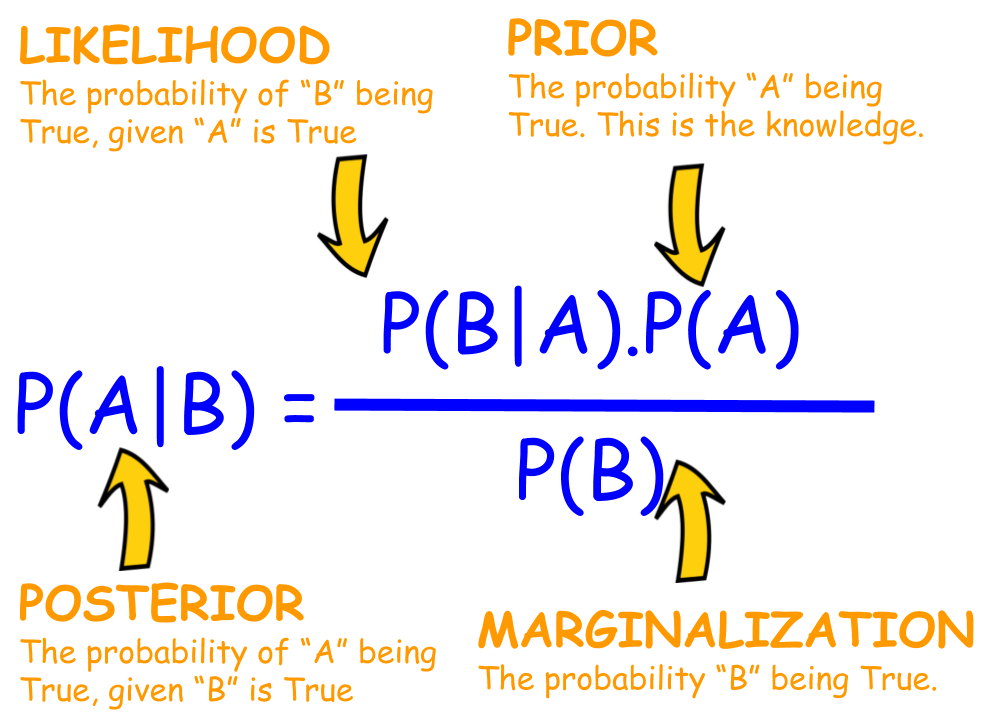

Source: https://mathematicalmysteries.org/bayes-theorem/

In [14]:
# Create Naive Bayes Classifier function
def Bayes_classifier(message):

    # Replicate pre-processing function
    message = message.translate(str.maketrans('', '', string.punctuation))
    message = message.lower()        
    message = [word for word in message.split() if word not in stopwords.words('english')] 

    # Make initial probability that message is spam/not-spam equal to probability that a random word is spam/not spam
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    # Iterate through words in message input to function
    # If word has a spam parameter, multiply that parameter by current probability that the message is spam
    # Same process for non-spam probabilities
    for word in message:
        if word in param_spam:
            p_spam_given_message *= param_spam[word]
        if word in param_ham:
            p_ham_given_message *= param_ham[word]

    # If probability that a message is spam is less than the probability it is not, return ham
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    
    # If probability that a message is spam is greater than the probability it is not, return spam
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    
    # If probabilities are equal, indicate message needs human classification
    else:
        return 'needs human classification'

In [15]:
# Same function as above, but also prints the probability that a message is spam/ham
def Bayes_classifier_probs(message):

    message = message.translate(str.maketrans('', '', string.punctuation))
    message = message.lower()        
    message = [word for word in message.split() if word not in stopwords.words('english')] 

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in param_spam:
            p_spam_given_message *= param_spam[word]
        if word in param_ham:
            p_ham_given_message *= param_ham[word]

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        return print('ham')
    elif p_ham_given_message < p_spam_given_message:
        return print('spam')
    else:
        return ('needs human classification')

In [16]:
def accuracy_test (testing):
    
    # Establish variable to keep track of number of correctly classified messages in test set
    correct = 0
    total = len(testing)
    
    # Iterates through dataframe
    for row in testing.iterrows():
        row = row[1]
        
        # Compares Label and predicted row and adds 1 to 'correct' variable of they are equal
        if row['Label']==row['predicted']:
            correct +=1
    return print('According to this test, the accuracy of the Naive Bayes spam filter is {:.1%}'.format(correct/total))

In [17]:
# Add column to testing dataframe to show what label the Bayes classifier predicted for each messages
testing['predicted'] = testing['SMS'].apply(Bayes_classifier)

print('Here are some sample predictions and how they compare with original labels:')
testing.head()

Here are some sample predictions and how they compare with original labels:


,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [18]:
# Calculate accuracy of Bayes Classifier on test set using accuracy function
accuracy_test(testing=testing)

According to this test, the accuracy of the Naive Bayes spam filter is 97.4%


In [19]:
# Test out Bayes Classifier on message we generated
Bayes_classifier_probs('WINNER!! This is the secret code to unlock the money: C3421.')


P(Spam|message): 6.352938452465077e-17
P(Ham|message): 2.4050579947241007e-19
spam


In [20]:
# Test out Bayes Classifier on message we generated
Bayes_classifier_probs("Sounds good, Tom, then see u there")

P(Spam|message): 2.522334308048636e-21
P(Ham|message): 2.0735745552836e-18
ham


In [21]:
# Create dataframe of messages that Bayes Classifier labeled incorrectly as spam
incorrectly_labeled = testing[(testing['Label']== 'ham')&(testing['predicted']=='spam')]

print(f'\033[1mHere are some of the non-spam messages that the Bayes Classifier incorrectly labeled as spam: \033[0m\n')
for message in incorrectly_labeled['SMS'].head(3):
    print(message)
    print('\n')

Here are some of the non-spam messages that the Bayes Classifier incorrectly labeled as spam: 

I liked the new mobile


 and  picking them up from various points


How was txting and driving




In [22]:
# Create dataframe of messages that Bayes Classifier labeled incorrectly as not spam
incorrectly_labeled = testing[(testing['Label']== 'spam')&(testing['predicted']=='ham')]

print(f'\033[1mHere are some of the spam messages that the Bayes Classifier incorrectly labeled as non-spam: \033[0m\n')
for message in incorrectly_labeled['SMS'].head(3):
    print(message)
    print('\n')

Here are some of the spam messages that the Bayes Classifier incorrectly labeled as non-spam: 

Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net


More people are dogging in your area now. Call 09090204448 and join like minded guys. Why not arrange 1 yourself. There's 1 this evening. A£1.50 minAPN LS278BB


Cashbin.co.uk (Get lots of cash this weekend!) www.cashbin.co.uk Dear Welcome to the weekend We have got our biggest and best EVER cash give away!! These..




---
One useful feature of our parameters is that we can see which words occured most in messages that were labeled spam in the training set. We can then use these words to see if we can create a message that a human would likely label as not-spam, but our algorithm will label as spam.

In [23]:
top_100_spam = []

# Iterate through word spam parameters and find word that appeared most in pre-processed spam messages
for item in sorted(param_spam.items(), key=lambda item: item[1], reverse=True)[:100]:
    a,b = item
    top_100_spam.append(a)
    
top_100_ham = []

# Iterate through word ham parameters and find word that appeared most in pre-processed ham messages
for item in sorted(param_ham.items(), key=lambda item: item[1], reverse=True)[:100]:
    a,b = item
    top_100_ham.append(a)

In [24]:
spam_not_ham = []

# Find 100 most common words that appeared most in pre-processed spam messages, but not in ham messages
for word in top_100_spam:
    if word not in top_100_ham:
        spam_not_ham.append(word)

print ('Here are the non-stopword words that were in the top 100 most common words for spam messages, but not in the top 100 words for ham messages:\n')
list(spam_not_ham)

Here are the non-stopword words that were in the top 100 most common words for spam messages, but not in the top 100 words for ham messages:



['free',
 'txt',
 'stop',
 'mobile',
 'claim',
 'reply',
 'prize',
 'nokia',
 'win',
 'urgent',
 'cash',
 'contact',
 'service',
 '16',
 'guaranteed',
 'chat',
 'tone',
 'customer',
 'per',
 'week',
 'awarded',
 'line',
 'po',
 '18',
 'draw',
 'message',
 'receive',
 'mins',
 'box',
 'latest',
 '150ppm',
 '1',
 '£1000',
 'video',
 'live',
 '£2000',
 'every',
 'award',
 'holiday',
 'ringtone',
 'landline',
 '500',
 'shows',
 'chance',
 'code',
 'camera',
 'orange',
 'selected',
 'apply',
 'sms',
 'msg',
 'tcs',
 '£150',
 'offer',
 'valid',
 'network',
 'mob',
 'collection',
 'cost',
 'find',
 'tones',
 '1st',
 '150p',
 'rate',
 'attempt',
 'entry',
 'delivery',
 '2nd',
 'collect',
 'bonus',
 'texts',
 'weekly',
 'club',
 '£100',
 '8007',
 'todays',
 '£500',
 '3',
 'music',
 'auction',
 '86688',
 '£5000']

In [25]:
# Create messages consisting mostly of words in above list
tricky_messages = ["every delivery service costs cash","holiday music","latest music service","chat on the phone",
                   "i draw the line","let's chat on the phone"]

In [26]:
# Test each message in tricky messages list
for message in tricky_messages:
    print(f'\033[1mMessage: \033[0m {message}')
    print(f'\033[1mLabel: \033[0m {Bayes_classifier(message)}\n')

Message:  every delivery service costs cash
Label:  spam

Message:  holiday music
Label:  spam

Message:  latest music service
Label:  spam

Message:  chat on the phone
Label:  spam

Message:  i draw the line
Label:  spam

Message:  let's chat on the phone
Label:  spam



As we can see, with the knowledge of words that are in the top 100 most likely to appear in spam messages and not in the top 100 for non-spam messages, it is possible to craft a message that could easily appear in a normal text conversation that would be labeled as spam by the Bayes Classifier. 

## Logistic Regression

For Logistic Regression, we will start by changing the labels from 'spam' and 'ham' to 1 if the message is spam and 0 if the message is not spam. We will also use the same pre-processing steps we used on messages before running them on the Naive Classifier.

In [27]:
# Convert Label to binary as indicator of spam or not
def Convert_to_bin(text):    
    if text == 'spam':
        text = 1
    else:
        text = 0
    return text

# Pre-process messages
clean_collection = collection.copy()[['SMS','Label']]
clean_collection['SMS']=clean_collection['SMS'].apply(text_preprocess)

# Change columns names to reflect new labels
clean_collection.rename(columns={'Label':'Spam'}, inplace =True)
clean_collection['Spam'] = clean_collection['Spam'].apply(Convert_to_bin)
clean_collection.head()

,SMS,Spam
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun say early hor u c already say,0
4,nah dont think goes usf lives around though,0


We will still split our dataset into training and testing sets. We will continue to keep the same ratios with 70% of our data being used for training.

In [28]:
# Split data into x and y training and testing sets
x = clean_collection['SMS'].values
y = clean_collection['Spam'].values
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.3, random_state=1)

In [29]:
# Turn texts into vectors
vec = CountVectorizer()
vec.fit(x_train)
x_train=vec.transform(x_train)
x_test=vec.transform(x_test)

In [30]:
# Create Logistic Regression models using sci-kit modules
spam_model = LogisticRegression(solver='liblinear', penalty='l1')

# Fit training labels to training word vector set
spam_model.fit(x_train, y_train)

# Predict labels from model
pred = spam_model.predict(x_test)

# Identify label accuracy from test set predictions
LR_accuracy = accuracy_score(y_test,pred)
print('\033[1mAccording to this test, the accuracy of the Logistic Regression spam filter is {:.1%}\033[1m'.format(LR_accuracy))

According to this test, the accuracy of the Logistic Regression spam filter is 96.9%


In [31]:
# Create logistic regression classifier that will work for individual messages
def Log_Reg_Classifier(message):
    # Turn message into a list
    message_list = [message]
#     vec = CountVectorizer(lowercase=False, preprocessor=None, tokenizer=None)
#     vec.fit(x_train)
    # Vectorize message
    message_matrix=vec.transform(message_list)
    pred = spam_model.predict(message_matrix)
    if pred == 0:
        return 'not spam'
    elif pred == 1:
        return 'spam'

In [32]:
# Test out Logistic Regression Classifier on message we generated
Log_Reg_Classifier('WINNER!! This is the secret code to unlock the money: C3421.')

'not spam'

In [33]:
# Test out Logistic Regression Classifier on message we generated
Log_Reg_Classifier("Sounds good, Tom, then see u there")

'not spam'

In [34]:
# Test out Logistic Regression Classifier on tricky messages:
for message in tricky_messages:
    print(f'\033[1mMessage: \033[0m {message}')
    print(f'\033[1mLabel: \033[0m {Log_Reg_Classifier(message)}\n')

Message:  every delivery service costs cash
Label:  spam

Message:  holiday music
Label:  not spam

Message:  latest music service
Label:  spam

Message:  chat on the phone
Label:  not spam

Message:  i draw the line
Label:  not spam

Message:  let's chat on the phone
Label:  not spam



In [35]:
# Test out Logistic Regression Classifier on message we generated
Log_Reg_Classifier('Nokia ringtone')

'spam'

In [36]:
# Test out Logistic Regression Classifier on message we generated
Log_Reg_Classifier('you win free money')

'not spam'

## Conclusion

Both the Naive Bayes and Logistics Regression spam filters correctly labeled messages as spam or not spam with about 97% accuracy. This seems very high, especially considering that Naive Bayes classifier only looked at the individual words used in the message. 

One option that exists is to tighten or loosen the requirements for messages being labeled as spam. As our models  currently exist, if a message has a 0.0001% higher chance of being spam than not spam, it gets labeled as spam. We could say that a message needs to be twice as likely to be spam in order to be labeled as spam. This would let in more spam, but would ensure that fewer non-spam messages do not get labeled as spam. The inverse of this is also possible if our desire is let fewer spam messages slip through a spam filter.


## Future Work

To increase the accuracy of our model, we could get the model to analyze sets of words. This would provide the model with more context around how each word is used. For instance, perhaps the words "free" and "money" are equally likely to be used in spam and non-spam messages, but the word set "free money" is used much more frequently in spam messages. This is called [n-gram analysis](https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058) (or bi-gram analysis in the case of two word sets). 